# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import cluster as c
from sklearn import metrics as m
from sklearn.decomposition import PCA
import sklearn.preprocessing as pp
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor

import umap

import pickle

from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from geopy.geocoders import Nominatim

from IPython.display import HTML, Image

## 0.1 Loading Dataset

In [2]:
prices = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\Price_AV_Itapema.csv', low_memory=False)
vivareal = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\VivaReal_Itapema.csv')
details = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\Details_Data.csv')
hosts = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\raw\\Hosts_ids_Itapema.csv')

## 0.2 Helper Functions

In [3]:
def get_district(x):
    geolocator = Nominatim(user_agent="geoapiExercises")
    lat = str(x[0])
    long = str(x[1])
    location = geolocator.reverse(lat+","+long, timeout=None)
    return location

def search_outliers(df, series):
    q1 = np.percentile(df[series], 25)
    q3 = np.percentile(df[series], 75)
    distancia = q3 - q1
    salto = distancia * 1.5
    li = q1 - salto
    ls = q3 + salto
    indices = df[(df[series]<li)|(df[series]>ls)].index
    return indices, li, ls

# 1.0 Data Description

## 1.1 Looking Datasets

In [4]:
prices.head()

,airbnb_listing_id,date,price,price_string,minimum_stay,available,aquisition_date,av_for_checkin,av_for_checkout,index,bookable,ano,mes,dia
0,22258063,2022-11-27,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
1,22258063,2022-11-28,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
2,22258063,2022-11-29,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
3,22258063,2022-11-30,460.0,R$460,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27
4,22258063,2022-12-01,500.0,R$500,2,True,2022-11-27 05:28:18.654,True,NaN,NaN,NaN,2022,11,27


In [5]:
vivareal.head(3)

,listing_id,link_name,link_url,listing_type,listing_title,listing_desc,business_types,unit_type,unit_subtype,property_type,...,advertiser_id,advertiser_name,advertiser_phones,advertiser_whatsapp,advertiser_url,portal,aquisition_date,ano,mes,dia
0,2570403797,"Apartamento com 4 Quartos à venda, 187m²",https://www.vivareal.com.br/imovel/apartamento...,USED,"Apartamento com 4 dormitórios à venda, 187 m² ...",Situado em uma das melhores regiões da Meia Pr...,"[""SALE""]",APARTMENT,NaN,UNIT,...,39507409-01f8-3935-dc38-e0fea684b44a,Winner Brokers,"[""44984349088""]",4.498435e+10,https://www.vivareal.com.br/770696/winner-brok...,GRUPOZAP,2022-12-06 00:00:00.000,2022,12,6
1,2510420914,"Apartamento com 4 Quartos à venda, 253m²",https://www.vivareal.com.br/imovel/apartamento...,USED,Apartamento com 4 suítes 3 vagas em Itapema SC,"Apartamentos com 04 suítes, 03 vagas de garage...","[""SALE""]",APARTMENT,NaN,UNIT,...,cc5bc87d-b746-8b05-90f8-ef61f5020a69,FRANCA FERRAZ IMOBILIARIA,"[""4733630740"", ""47996961130""]",4.799696e+10,https://www.vivareal.com.br/116267/franca-ferr...,GRUPOZAP,2022-12-06 00:00:00.000,2022,12,6
2,2594648655,"Apartamento com 4 Quartos à venda, 210m²",https://www.vivareal.com.br/imovel/apartamento...,USED,"Apartamento à venda, Centro, Itapema, SC","Apartamento à Venda, 210m² por R$ 3.000.000. C...","[""SALE""]",APARTMENT,NaN,UNIT,...,ac9f84ae-1363-d2aa-1a6d-4adf1631539f,ARBO IMÓVEIS,"[""11999293012""]",1.199929e+10,https://www.vivareal.com.br/656548/arbo-imoveis/,GRUPOZAP,2022-12-06 00:00:00.000,2022,12,6


In [6]:
details.head(3)

,aquisition_date,url,ad_name,ad_description,ad_id,space,house_rules,amenities,safety_features,number_of_bathrooms,...,index,localized_star_rating,response_time_shown,response_rate_shown,guest_satisfaction_overall,picture_count,min_nights,ano,mes,dia
0,2022-07-11 07:21:51.61831,https://www.airbnb.com.br/rooms/27865733,Carambei 106,"Apartamento para 8 pessoas, lateral p praia. P...",27865733,Espaco TOP tipo hotel,"{""Não são permitidas festas ou eventos"",""Anima...","{Cabides,""Ferro de passar"",""Máquina de Lavar"",...",{},2.0,...,11043701.0,NaN,em até uma hora,100%,100.0,31.0,2.0,2022,7,11
1,2022-07-11 07:28:25.226756,https://www.airbnb.com.br/rooms/52200210,Apto aconchegante na rua + procurada da Meia P...,Sua família vai estar perto de tudo ao ficar n...,52200210,NaN,"{""Animais de estimação são permitidos""}","{""Máquina de Lavar"",TV,Ar-condicionado,Wi-Fi,""...",{},2.0,...,11082903.0,"5,0",em até uma hora,100%,100.0,43.0,2.0,2022,7,11
2,2022-07-18 07:19:40.053547,https://www.airbnb.com.br/rooms/53372578,Ótimo apartamento em Itapema,Ótimo para período de férias,53372578,"O Ap é bastante amplo, sala de star e jantar i...","{""Animais de estimação são permitidos""}","{""Local para guardar as roupas"",""Blackout nas ...","{""Extintor de incêndio""}",2.0,...,11300813.0,"3,0",NaN,NaN,60.0,11.0,7.0,2022,7,18


In [7]:
hosts.head(3)

,host_id,host_name,host_rating,n_reviews,n_reviews_from_host,n_listings,about_host,comments,aquisition_date,ano,mes,dia
0,160913639,Cayo,0.000,0,0,1,NaN,NaN,2022-12-05,2022,12,5
1,84162292,Ricardo,4.935,42,1,3,"Sou casado, tenho uma filha de 9 anos e um fil...","[""Obrigado Ricardo a estadia foi ótima muito ...",2022-12-05,2022,12,5
2,96045548,Eduardo,0.000,26,0,3,NaN,"[""Otimo"", ""muito bom local e muito claro nas e...",2022-12-05,2022,12,5


## 1.2 Data Dimensions

In [8]:
print('prices')
print(f'Rows qtd: {prices.shape[0]}')
print(f'Columns qtd: {prices.shape[1]}\n')
print('vivareal')
print(f'Rows qtd: {vivareal.shape[0]}')
print(f'Columns qtd: {vivareal.shape[1]}\n')
print('details')
print(f'Rows qtd: {details.shape[0]}')
print(f'Columns qtd: {details.shape[1]}\n')
print('hosts')
print(f'Rows qtd: {hosts.shape[0]}')
print(f'Columns qtd: {hosts.shape[1]}\n')

prices
Rows qtd: 43020080
Columns qtd: 14

vivareal
Rows qtd: 17547
Columns qtd: 42

details
Rows qtd: 32558
Columns qtd: 37

hosts
Rows qtd: 1357
Columns qtd: 12



## 1.3 Datatypes

In [9]:
prices.dtypes

airbnb_listing_id      int64
date                  object
price                float64
price_string          object
minimum_stay           int64
available               bool
aquisition_date       object
av_for_checkin        object
av_for_checkout      float64
index                float64
bookable             float64
ano                    int64
mes                    int64
dia                    int64
dtype: object

In [10]:
hosts.dtypes

host_id                  int64
host_name               object
host_rating            float64
n_reviews                int64
n_reviews_from_host      int64
n_listings               int64
about_host              object
comments                object
aquisition_date         object
ano                      int64
mes                      int64
dia                      int64
dtype: object

In [11]:
details.dtypes

aquisition_date                object
url                            object
ad_name                        object
ad_description                 object
ad_id                           int64
space                          object
house_rules                    object
amenities                      object
safety_features                object
number_of_bathrooms           float64
number_of_bedrooms            float64
number_of_beds                float64
latitude                      float64
longitude                     float64
star_rating                   float64
additional_house_rules         object
owner                          object
check_in                       object
check_out                      object
number_of_guests                int64
is_superhost                     bool
number_of_reviews               int64
cohosts                        object
cleaning_fee                  float64
can_instant_book                 bool
owner_id                        int64
listing_type

In [12]:
vivareal.dtypes

listing_id                 int64
link_name                 object
link_url                  object
listing_type              object
listing_title             object
listing_desc              object
business_types            object
unit_type                 object
unit_subtype              object
property_type             object
usage_type                object
sale_price               float64
rental_price             float64
rental_period             object
yearly_iptu              float64
monthly_condo_fee        float64
amenities                 object
usable_area              float64
total_area               float64
bathrooms                float64
bedrooms                 float64
suites                   float64
parking_spaces           float64
address_country           object
address_state             object
address_city              object
address_neighborhood      object
address_street            object
address_street_number     object
address_complement       float64
address_zi

## 1.4 Check Na

In [13]:
round(prices.isna().sum() / prices['airbnb_listing_id'].count() * 100, 2)

airbnb_listing_id      0.00
date                   0.00
price                  0.01
price_string           0.00
minimum_stay           0.00
available              0.00
aquisition_date        0.00
av_for_checkin         0.09
av_for_checkout      100.00
index                100.00
bookable             100.00
ano                    0.00
mes                    0.00
dia                    0.00
dtype: float64

In [14]:
round(hosts.isna().sum() / hosts['host_id'].count() * 100, 2)

host_id                 0.00
host_name               0.00
host_rating             0.00
n_reviews               0.00
n_reviews_from_host     0.00
n_listings              0.00
about_host             76.05
comments               21.81
aquisition_date         0.00
ano                     0.00
mes                     0.00
dia                     0.00
dtype: float64

In [15]:
round(details.isna().sum() / details['aquisition_date'].count() * 100, 2)

aquisition_date                0.00
url                            0.00
ad_name                        0.00
ad_description                 5.75
ad_id                          0.00
space                         47.46
house_rules                    9.48
amenities                      0.00
safety_features                0.00
number_of_bathrooms            0.23
number_of_bedrooms             1.59
number_of_beds                 0.57
latitude                       0.00
longitude                      0.00
star_rating                   47.69
additional_house_rules        57.24
owner                          0.00
check_in                       8.31
check_out                     20.60
number_of_guests               0.00
is_superhost                   0.00
number_of_reviews              0.00
cohosts                       87.16
cleaning_fee                   0.00
can_instant_book               0.00
owner_id                       0.00
listing_type                   0.00
index                       

In [16]:
round(vivareal.isna().sum() / vivareal['listing_id'].count() * 100, 2)

listing_id                 0.00
link_name                  0.00
link_url                   0.00
listing_type               0.00
listing_title              0.06
listing_desc               0.54
business_types             0.00
unit_type                  0.00
unit_subtype              98.66
property_type              0.00
usage_type                 0.00
sale_price                 6.42
rental_price              93.35
rental_period             93.35
yearly_iptu               56.64
monthly_condo_fee         56.39
amenities                  0.00
usable_area                0.03
total_area                11.81
bathrooms                  0.23
bedrooms                   0.51
suites                     7.06
parking_spaces             4.47
address_country            0.00
address_state              0.00
address_city               0.00
address_neighborhood       5.37
address_street            38.38
address_street_number     41.03
address_complement       100.00
address_zipcode            0.10
location

## 1.5 Fillout Na

In [17]:
map_bedrooms = details.groupby('number_of_guests').agg({'number_of_bedrooms':'mean'})['number_of_bedrooms'].round()
temp = details.loc[details['number_of_bedrooms'].isna(), 'number_of_guests'].map(map_bedrooms).values
details.loc[details['number_of_bedrooms'].isna(), 'number_of_bedrooms'] = temp

map_bathrooms = details.groupby('number_of_guests').agg({'number_of_bathrooms':'mean'})['number_of_bathrooms'].round()
temp = details.loc[details['number_of_bathrooms'].isna(), 'number_of_guests'].map(map_bathrooms).values
details.loc[details['number_of_bathrooms'].isna(), 'number_of_bathrooms'] = temp

map_beds = details.groupby('number_of_guests').agg({'number_of_beds':'mean'})['number_of_beds'].round()
temp = details.loc[details['number_of_beds'].isna(), 'number_of_guests'].map(map_beds).values
details.loc[details['number_of_beds'].isna(), 'number_of_beds'] = temp

## 1.6 Rename Columns

In [18]:
prices.rename(columns={'airbnb_listing_id':'airbnb_id'}, inplace=True)
details.rename(columns={'ad_id':'airbnb_id'}, inplace=True)

## 1.7 Data Cleaning

In [19]:
details['safety_features'] = details['safety_features'].apply(lambda x: re.sub('[^a-zA-Z0-9\n.çêó]', ' ', x))
details['safety_features'] = details['safety_features'].str.replace(' ', '')
details['safety_features'] = details['safety_features'].str.replace('Trancanaportadoquarto','')
details['safety_features'] = details['safety_features'].str.replace('u00ea', 'ê')
details['safety_features'] = details['safety_features'].str.replace('u00e7', 'ç')
details['safety_features'] = details['safety_features'].str.replace('u00f3', 'ó')
temp = 'Extintordeincêndio Detectordefumaça Alarmedemonóxidodecarbono Kitdeprimeirossocorros'.split()
details['extintordeincendio'] = details['safety_features'].apply(lambda x: 1 if temp[0] in x else 0)
details['detectordefumaça'] = details['safety_features'].apply(lambda x: 1 if temp[1] in x else 0)
details['alarmedemonoxidodecarbono'] = details['safety_features'].apply(lambda x: 1 if temp[2] in x else 0)
details['kitdeprimeirossocorros'] = details['safety_features'].apply(lambda x: 1 if temp[3] in x else 0)
details.loc[details['number_of_bathrooms']==0, 'number_of_bathrooms'] = 4

prices = prices[~prices[['airbnb_id', 'date']].duplicated()]
prices['available'] = prices['available'].apply(lambda x: 1 if x==True else 0)
prices.loc[prices['price'] >= 4000, 'price'] = np.nan
map_price = prices.groupby('airbnb_id').agg({'price':'median'})['price']
temp = prices.loc[prices['price'].isna(), 'airbnb_id'].map(map_price)
prices.loc[prices['price'].isna(), 'price'] = temp

## 1.8 Changing Datatipes

In [20]:
prices['available'] = prices['available'].astype(int)
prices['date'] = pd.to_datetime(prices['date'])

details['number_of_bathrooms'] = details['number_of_bathrooms'].astype(int)
details['number_of_bedrooms'] = details['number_of_bedrooms'].astype(int)
details['number_of_beds'] = details['number_of_beds'].astype(int)

## 1.9 Integrating Dataframes

### 1.9.1 Merging

In [21]:
df = prices[['airbnb_id', 'date', 'price', 'available']]

temp = details[['airbnb_id', 'cleaning_fee', 'number_of_bathrooms', 'number_of_bedrooms', 'number_of_beds', 'number_of_guests', 'extintordeincendio', 'detectordefumaça', 'alarmedemonoxidodecarbono', 'kitdeprimeirossocorros', 'latitude', 'longitude']]
temp = temp.groupby('airbnb_id').median()

df = pd.merge(df, temp, on='airbnb_id', how='left')

### 1.9.2 Data Dimension

In [22]:
print(f'Quantity of rows: {df.shape[0]}')
print(f'Quantity of columns: {df.shape[1]}')

Quantity of rows: 968832
Quantity of columns: 15


### 1.9.3 Check Na

In [23]:
df.isna().sum() / df['airbnb_id'].count()

airbnb_id                    0.000000
date                         0.000000
price                        0.004676
available                    0.000000
cleaning_fee                 0.000000
number_of_bathrooms          0.000000
number_of_bedrooms           0.000000
number_of_beds               0.000000
number_of_guests             0.000000
extintordeincendio           0.000000
detectordefumaça             0.000000
alarmedemonoxidodecarbono    0.000000
kitdeprimeirossocorros       0.000000
latitude                     0.000000
longitude                    0.000000
dtype: float64

### 1.9.4 Fillout Na

In [24]:
df.dropna(inplace=True)

## 1.10 Descriptive Statistical

In [25]:
num_attributes = ['price', 'number_of_bathrooms', 'number_of_bedrooms', 'number_of_beds', 'number_of_guests']

### 1.10.1 Numerical Attributes

In [26]:
# Central tendency
ct1 = pd.DataFrame(df[num_attributes].apply(np.mean)).T
ct2 = pd.DataFrame(df[num_attributes].apply(np.median)).T

# Dispersion
d1 = pd.DataFrame(df[num_attributes].apply(np.std)).T
d2 = pd.DataFrame(df[num_attributes].apply(min)).T
d3 = pd.DataFrame(df[num_attributes].apply(max)).T
d4 = pd.DataFrame(df[num_attributes].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df[num_attributes].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df[num_attributes].apply(lambda x: x.kurtosis())).T

# Concat
temp = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
temp.columns = 'min max range mean median std skew kurtosis'.split()
temp

,min,max,range,mean,median,std,skew,kurtosis
price,48.0,3999.0,3951.0,653.151431,500.0,515.326681,2.164565,6.201540
number_of_bathrooms,1.0,12.0,11.0,2.171190,2.0,0.924098,1.417277,6.828662
number_of_bedrooms,1.0,12.0,11.0,2.591521,3.0,0.906626,1.001365,7.592063
number_of_beds,0.0,50.0,50.0,3.729571,3.0,2.203981,6.324022,104.438559
number_of_guests,1.0,16.0,15.0,6.829188,6.0,2.509208,0.588525,1.442994


In [27]:
df.describe()

,airbnb_id,price,available,cleaning_fee,number_of_bathrooms,number_of_bedrooms,number_of_beds,number_of_guests,extintordeincendio,detectordefumaça,alarmedemonoxidodecarbono,kitdeprimeirossocorros,latitude,longitude
count,9.643020e+05,964302.000000,964302.000000,964302.000000,964302.000000,964302.000000,964302.000000,964302.000000,964302.000000,964302.000000,964302.000000,964302.000000,964302.000000,964302.000000
mean,1.860284e+17,653.151431,0.630679,190.672709,2.171190,2.591521,3.729571,6.829188,0.424941,0.111957,0.052576,0.040188,-27.124552,-48.602041
std,3.112965e+17,515.326948,0.482621,108.724536,0.924099,0.906627,2.203983,2.509210,0.494334,0.315313,0.223185,0.196399,0.020563,0.011934
min,1.977915e+06,48.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-27.159970,-48.660860
25%,3.881820e+07,300.000000,0.000000,150.000000,2.000000,2.000000,3.000000,6.000000,0.000000,0.000000,0.000000,0.000000,-27.137000,-48.610730
50%,4.727499e+07,500.000000,1.000000,200.000000,2.000000,3.000000,3.000000,6.000000,0.000000,0.000000,0.000000,0.000000,-27.129900,-48.602500
75%,5.587190e+17,800.000000,1.000000,250.000000,3.000000,3.000000,5.000000,8.000000,1.000000,0.000000,0.000000,0.000000,-27.117030,-48.595550
max,7.712687e+17,3999.000000,1.000000,790.000000,12.000000,12.000000,50.000000,16.000000,1.000000,1.000000,1.000000,1.000000,-27.050020,-48.560320


<AxesSubplot: >

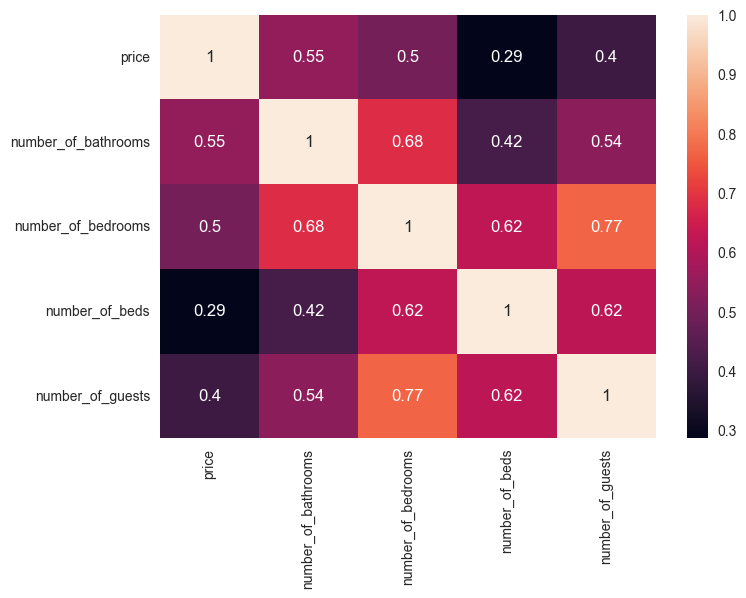

In [28]:
sns.heatmap(df[num_attributes].corr(), annot=True)

### 1.10.2 Categorical Attributes

# 2.0 Feature Engineering

In [29]:
# filtering by sold only
df = df[df['available']==0]

In [30]:
# data reference
df_ref = df[['airbnb_id']].drop_duplicates(ignore_index=True)

# lifetime value
# monetary
temp = df.groupby('airbnb_id').agg({'price':'sum'}).reset_index().rename(columns=({'price':'gross_revenue'}))
df_ref = pd.merge(df_ref, temp, on='airbnb_id', how='left')

# recency
max_date = prices['date'].max().strftime('%Y-%m-%d')
min_date = prices['date'].min().strftime('%Y-%m-%d')
min_date = pd.to_datetime(min_date)
max_date = pd.to_datetime(max_date)
date_delta = (max_date - min_date).days + 1
temp = df.groupby('airbnb_id').agg({'date':'max'}).reset_index().rename(columns=({'date':'last_revenue'}))
temp['recency'] = (max_date - temp['last_revenue']).dt.days
temp.drop(['last_revenue'], axis=1, inplace=True)
df_ref = pd.merge(df_ref, temp, on='airbnb_id', how='left')

# frequency
temp = df.groupby('airbnb_id').agg({'price':'count'}).reset_index().rename(columns=({'price':'quantity_sell'}))
temp['frequency'] = (date_delta / temp['quantity_sell'])
temp.drop('quantity_sell', axis=1, inplace=True)
df_ref = pd.merge(df_ref, temp, on='airbnb_id', how='left')

# 3.0 Exploratory Data Analysis

In [31]:
df3 = df_ref.copy()

## 3.1 Univariate Analysis

## 3.2 Bivariate Analysis

## 3.3 Space Study

### 3.3.1 Preprocessing

#### 3.3.1.1 Normalize

In [32]:
# frequency
ss_frequency = pp.StandardScaler()
ss_frequency = ss_frequency.fit(df3[['frequency']].values)
df3['frequency'] = ss_frequency.transform(df3[['frequency']].values)

# gross_revenue
df3['gross_revenue'] = np.log1p(df3['gross_revenue'])

# recency
df3['recency'] = np.log1p(df3['recency'])

#### 3.3.1.2 Rescaling

In [33]:
# gross_revenue
mm_gross_revenue = pp.MinMaxScaler()
mm_gross_revenue = mm_gross_revenue.fit(df3[['gross_revenue']].values)
df3['gross_revenue'] = mm_gross_revenue.transform(df3[['gross_revenue']].values)

# recency
mm_recency = pp.MinMaxScaler()
mm_recency = mm_recency.fit(df3[['recency']].values)
df3['recency'] = mm_recency.transform(df3[['recency']].values)

# frequency
mm_frequency = pp.MinMaxScaler()
mm_frequency = mm_frequency.fit(df3[['frequency']].values)
df3['frequency'] = mm_frequency.transform(df3[['frequency']].values)

#### 3.3.1.3 Splits

In [34]:
X = df3[['gross_revenue', 'recency', 'frequency']]

### 3.3.2 Modeling

#### 3.3.2.1 PCA

In [ ]:
# model definition
pca = PCA(n_components=X.shape[1])

# fiting
principal_components = pca.fit_transform(X)

# pca component
X_ = pd.DataFrame(principal_components)

In [ ]:
# variance plot
features = range(pca.n_components_)
plt.figure(figsize=(20, 5))
plt.bar(features, pca.explained_variance_ratio_, color='black');

In [ ]:
# scatter plot
plt.figure(figsize=(20, 5))
sns.scatterplot(x=0, y=1, data=X_, color='black');

In [ ]:
clusters = [2, 3, 4, 5]

plt.figure(figsize=(20, 20))
for j, i in enumerate(clusters):
    j = j + 1
    j = j * 2
    # model definition
    kmeans = c.KMeans(n_clusters=i,
                      init='k-means++',
                      n_init=10,
                      max_iter=300,
                      random_state=100)
    # model training
    kmeans.fit(X_[[0, 1]])
    X_['y'] = kmeans.labels_
    
    # dot plot
    plt.subplot(4, 2, j - 1)
    sns.scatterplot(data=X_, x=0, y=1, hue='y', palette="bright")
    plt.title(f'Com {i} Clusters', fontsize=20)
    plt.xlabel('')
    plt.ylabel('')
    sns.despine()

    # silhouette visualizer
    plt.subplot(4, 2, j)
    visualizer = SilhouetteVisualizer(estimator=kmeans)
    visualizer.fit(X_[[0, 1]])
    visualizer.finalize()
    plt.title(f'Com {i} Clusters', fontsize=20)
    plt.xlabel('')
    plt.ylabel('')
    sns.despine()

#### 3.3.2.2 UMAP

In [ ]:
# model definition
reducer = umap.UMAP(random_state=100)
embedding = reducer.fit_transform(X)

In [ ]:
# embedding
X_ = pd.DataFrame()
X_[0] = embedding[:, 0]
X_[1] = embedding[:, 1]

In [ ]:
# plot
plt.figure(figsize=(20, 5))
sns.scatterplot(data=X_, x=0, y=1, color='black');

In [ ]:
clusters = [2, 3, 4, 5]

plt.figure(figsize=(20, 20))
for j, i in enumerate(clusters):
    j = j + 1
    j = j * 2
    # model definition
    kmeans = c.KMeans(n_clusters=i,
                      init='k-means++',
                      n_init=10,
                      max_iter=300,
                      random_state=100)
    # model training
    kmeans.fit(X_[[0, 1]])
    X_['y'] = kmeans.labels_
    
    # dot plot
    plt.subplot(4, 2, j - 1)
    sns.scatterplot(data=X_, x=0, y=1, hue='y', palette="bright")
    plt.title(f'Com {i} Clusters', fontsize=20)
    plt.xlabel('')
    plt.ylabel('')
    sns.despine()

    # silhouette visualizer
    plt.subplot(4, 2, j)
    visualizer = SilhouetteVisualizer(estimator=kmeans)
    visualizer.fit(X_[[0, 1]])
    visualizer.finalize()
    plt.title(f'Com {i} Clusters', fontsize=20)
    plt.xlabel('')
    plt.ylabel('')
    sns.despine()

#### 3.3.2.3 T-SNE

In [43]:
# model definition
reducer = TSNE(random_state=100, n_components=2, n_jobs=-1)
embedding = reducer.fit_transform(X)

In [44]:
# embedding
X_ = pd.DataFrame()
X_[0] = embedding[:, 0]
X_[1] = embedding[:, 1]

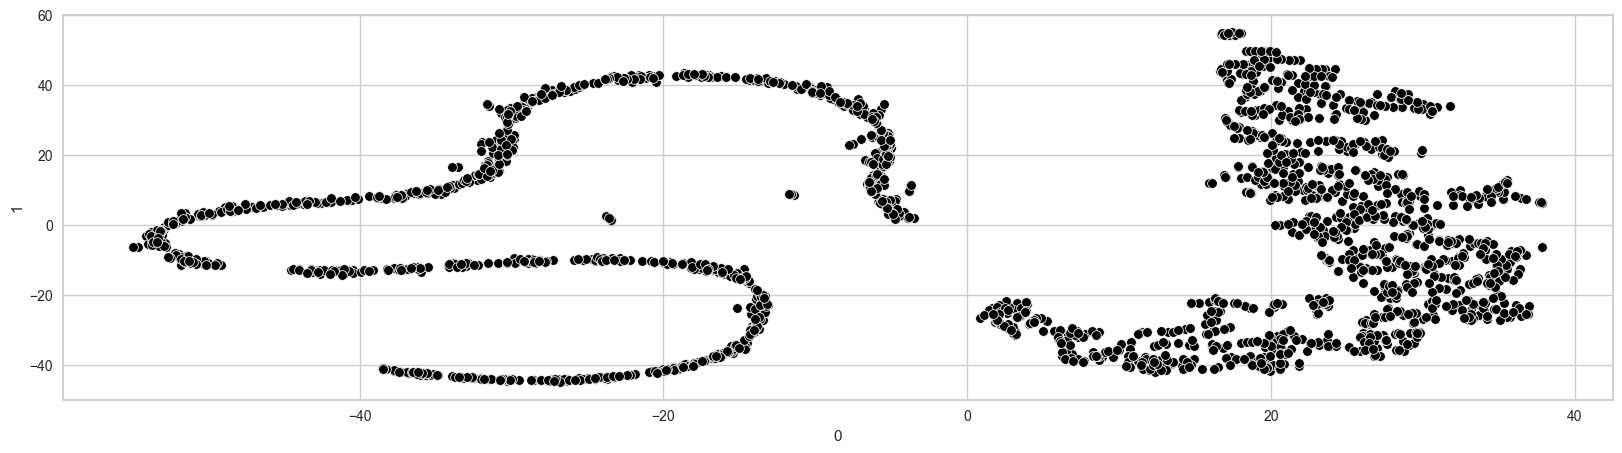

In [45]:
# plot
plt.figure(figsize=(20, 5))
sns.scatterplot(data=X_, x=0, y=1, color='black');

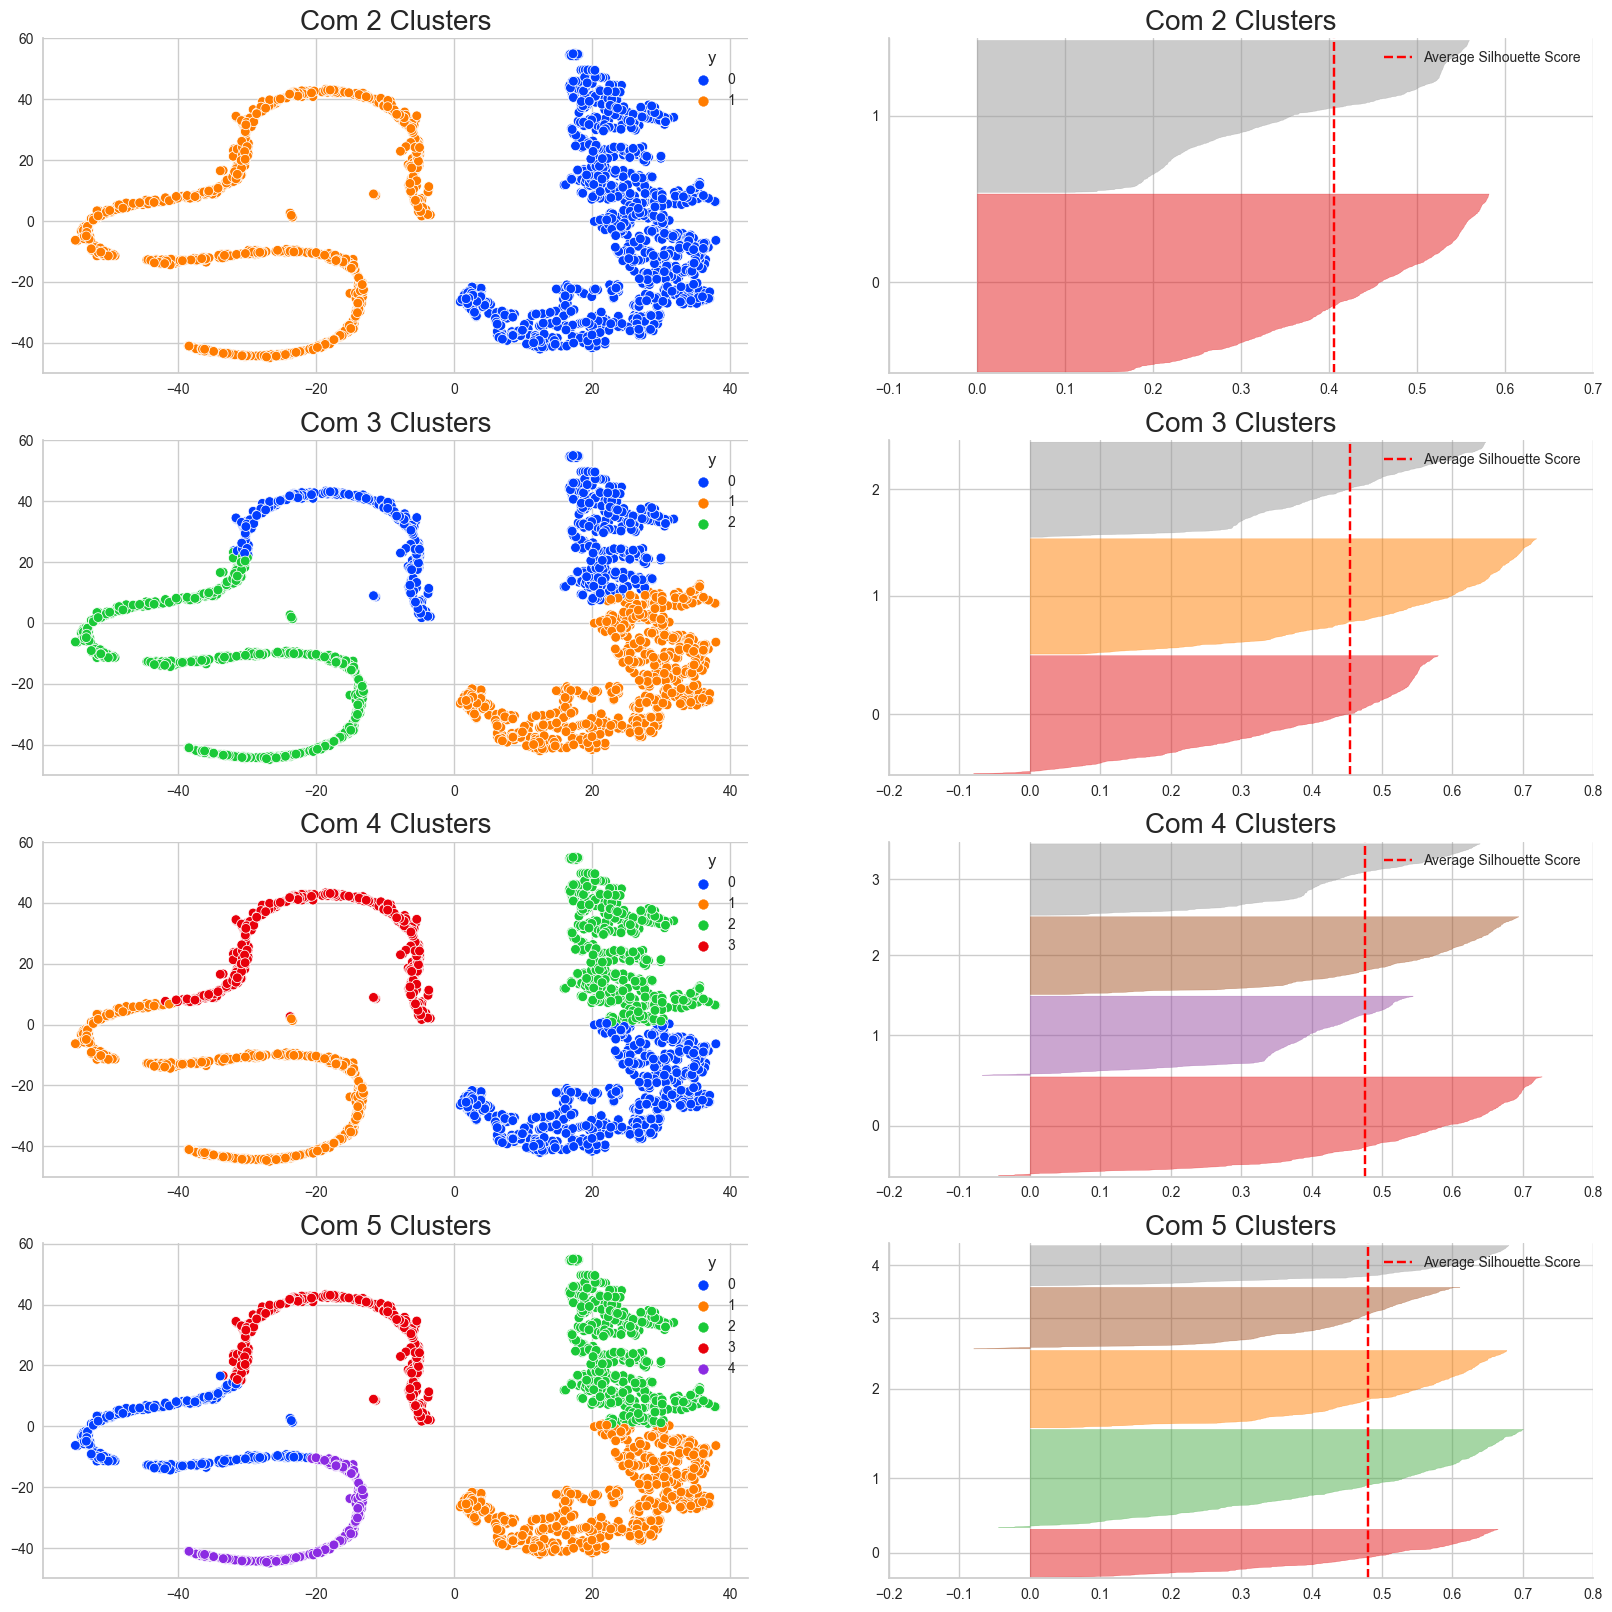

In [46]:
clusters = [2, 3, 4, 5]

plt.figure(figsize=(20, 20))
for j, i in enumerate(clusters):
    j = j + 1
    j = j * 2
    # model definition
    kmeans = c.KMeans(n_clusters=i,
                      init='k-means++',
                      n_init=10,
                      max_iter=300,
                      random_state=100)
    # model training
    kmeans.fit(X_[[0, 1]])
    X_['y'] = kmeans.labels_
    
    # dot plot
    plt.subplot(4, 2, j - 1)
    sns.scatterplot(data=X_, x=0, y=1, hue='y', palette="bright")
    plt.title(f'Com {i} Clusters', fontsize=20)
    plt.xlabel('')
    plt.ylabel('')
    sns.despine()

    # silhouette visualizer
    plt.subplot(4, 2, j)
    visualizer = SilhouetteVisualizer(estimator=kmeans)
    visualizer.fit(X_[[0, 1]])
    visualizer.finalize()
    plt.title(f'Com {i} Clusters', fontsize=20)
    plt.xlabel('')
    plt.ylabel('')
    sns.despine()

#### 3.3.2.4 Tree-Based Embedding

In [ ]:
# split
X_= X[['recency', 'frequency']].values
y_ = X['gross_revenue'].values

# model definition
rf_model = RandomForestRegressor(n_estimators=100, random_state=100)

# training
rf_model.fit(X_, y_)

# creating space
df_leaf = pd.DataFrame(rf_model.apply(X_))

In [ ]:
# reducer definition
reducer = TSNE(random_state=100, n_components=2, n_jobs=-1)
embedding = reducer.fit_transform(df_leaf)

In [ ]:
# embedding
X_ = pd.DataFrame()
X_[0] = embedding[:, 0]
X_[1] = embedding[:, 1]

In [ ]:
# plot
plt.figure(figsize=(20, 5))
sns.scatterplot(data=X_, x=0, y=1, color='black');

In [ ]:
clusters = [2, 3, 4, 5]

plt.figure(figsize=(20, 20))
for j, i in enumerate(clusters):
    j = j + 1
    j = j * 2
    # model definition
    kmeans = c.KMeans(n_clusters=i,
                      init='k-means++',
                      n_init=10,
                      max_iter=300,
                      random_state=100)
    # model training
    kmeans.fit(X_[[0, 1]])
    X_['y'] = kmeans.labels_
    
    # dot plot
    plt.subplot(4, 2, j - 1)
    sns.scatterplot(data=X_, x=0, y=1, hue='y', palette="bright")
    plt.title(f'Com {i} Clusters', fontsize=20)
    plt.xlabel('')
    plt.ylabel('')
    sns.despine()

    # silhouette visualizer
    plt.subplot(4, 2, j)
    visualizer = SilhouetteVisualizer(estimator=kmeans)
    visualizer.fit(X_[[0, 1]])
    visualizer.finalize()
    plt.title(f'Com {i} Clusters', fontsize=20)
    plt.xlabel('')
    plt.ylabel('')
    sns.despine()

# 4.0 Data Filtering

## 4.1 Columns Filtering

## 4.2 Rows Filtering

# 5.0 Data Preparation

# 6.0 Feature Selection

# 7.0 Hyperparameter Fine-tuning

In [52]:
X = df_ref.drop('airbnb_id', axis=1)

## 7.1 Within-Cluster Sum of Square (WSS)

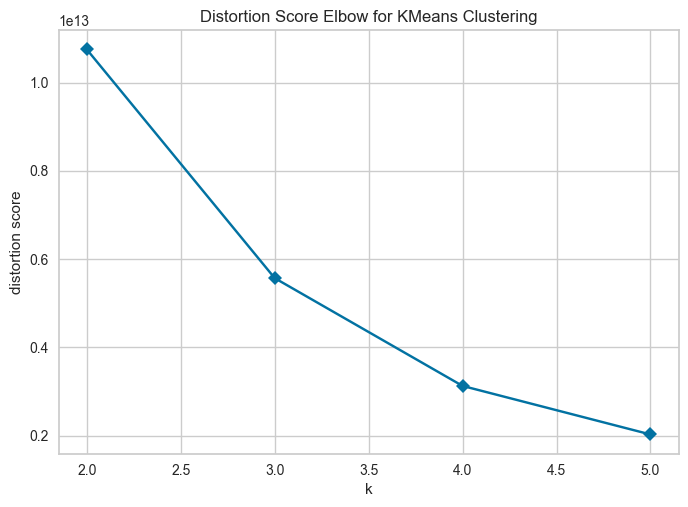

In [53]:
clusters = [2, 3, 4, 5]
kmeans = KElbowVisualizer(c.KMeans(n_init=10), k=clusters, timings=False, locate_elbow=False)
kmeans.fit(X)
kmeans.show();

## 7.2 Silhouette Score

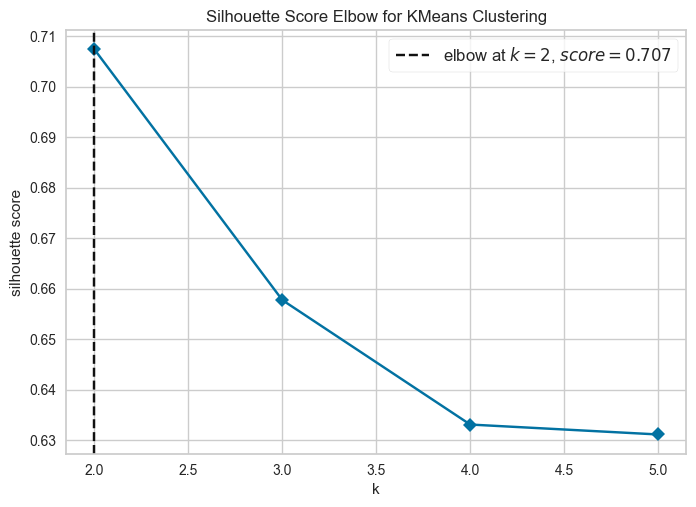

In [54]:
clusters = [2, 3, 4, 5]
kmeans = KElbowVisualizer(c.KMeans(n_init=10), metric='silhouette', k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

# 8.0 Clustering Model Training

In [55]:
k = 2

# model definition
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=100)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_
df_ref['cluster'] = labels

# df_ref['cluster'] = df_ref['cluster'].apply(lambda x: 2 if x==1 else (1 if x==2 else 0))

In [56]:
# WSS (Within-cluster sum of squares)
print(f'WSS value: {kmeans.inertia_}')

# SS (silhouette)
print(f'SS value: {m.silhouette_score(X, labels, metric="euclidean")}')

WSS value: 10748690416199.215
SS value: 0.7073697448081276


# 9.0 Clustering Technical Analysis

## 9.1 Visual Inpection

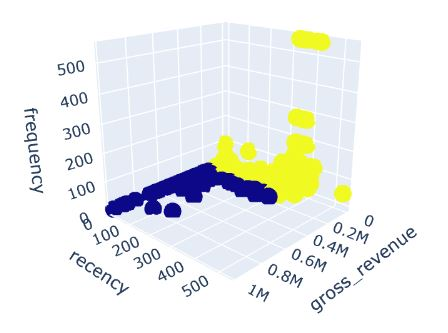

In [371]:
fig = px.scatter_3d(df_ref, x='gross_revenue', y='recency', z='frequency', color='cluster')
# fig.show()
Image('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\img\\3d_plot.jpg')

## 9.3 Cluster Profile

In [58]:
# Number of customers
profile = df_ref.groupby('cluster').agg({'airbnb_id':'count'}).reset_index().rename(columns={'airbnb_id':'number_of_customers'})
# Proportional number of customers
profile['prop_number_of_customers'] = profile['number_of_customers']  / np.sum(profile['number_of_customers'])
# Avg Gross Revenue
temp = df_ref.groupby('cluster').agg({'gross_revenue': 'mean'}).reset_index().rename(columns={'gross_revenue':'avg_gross_revenue'})
profile['avg_gross_revenue'] = temp['avg_gross_revenue']
# Proportional gross revenue
temp = df_ref.groupby('cluster').agg({'gross_revenue':'sum'}).reset_index().rename(columns={'gross_revenue':'sum_gross_revenue'})
profile['prop_gross_revenue'] = temp['sum_gross_revenue'] / np.sum(temp['sum_gross_revenue'])
# Avg Recency days
temp = df_ref.groupby('cluster').agg({'recency': 'mean'}).reset_index().rename(columns={'recency':'avg_recency_days'})
profile['avg_recency_days'] = temp['avg_recency_days']
# Avg Frequency
temp = df_ref.groupby('cluster').agg({'frequency': 'mean'}).reset_index().rename(columns={'frequency':'avg_frequency'})
profile['avg_frequency'] = temp['avg_frequency']
profile

,cluster,number_of_customers,prop_number_of_customers,avg_gross_revenue,prop_gross_revenue,avg_recency_days,avg_frequency
0,0,350,0.159744,300098.131429,0.504728,10.688571,1.962686
1,1,1841,0.840256,55984.083379,0.495272,182.559479,26.034258


### Cluster 0
* Number of customers: 350 (16% of total)
* 50% of total gross revenue
* Avarage gross revenue: 300098.13
* Avarage Recency: 11 days
* Average frequency every 2 days

### Cluster 1
* Number of customers: 1841 (84% of total)
* 50% of total gross revenue
* Avarage gross revenue: 55984.08
* Avarage Recency: 183 days
* Average frequency every 26 days

# 10.0 Cluster Business Analysis

In [59]:
temp = df.groupby('airbnb_id').agg({'number_of_bathrooms':'max', 'number_of_bedrooms':'max', 'number_of_beds':'max', 'extintordeincendio':'max', 'detectordefumaça':'max', 'alarmedemonoxidodecarbono':'max', 'kitdeprimeirossocorros':'max', 'latitude':'first', 'longitude':'first'}).reset_index()

df10 = pd.merge(df_ref, temp, on='airbnb_id', how='left')

## 10.1 Cluster Profile

### 10.1.1 Number of Bedrooms

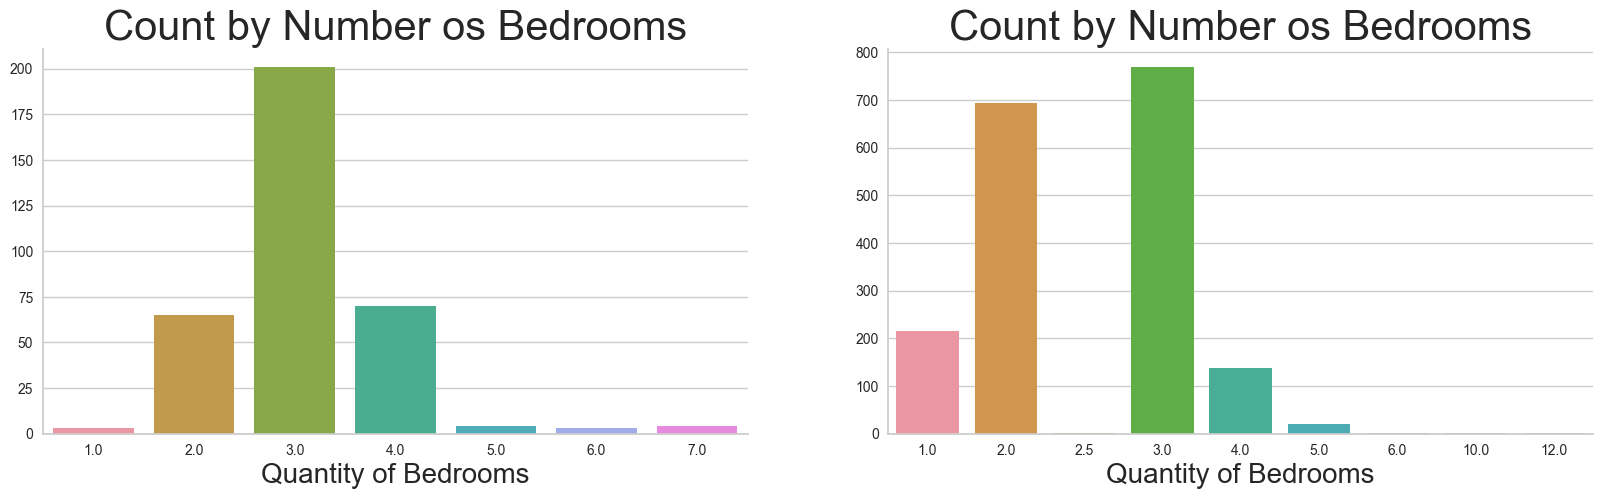

In [60]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df10.loc[df10['cluster']==0] , x='number_of_bedrooms')
plt.title('Count by Number os Bedrooms', fontsize=30)
plt.xlabel('Quantity of Bedrooms', fontsize=20)
plt.ylabel('')
sns.despine()
plt.subplot(1, 2, 2)
sns.countplot(data=df10.loc[df10['cluster']==1] , x='number_of_bedrooms')
plt.title('Count by Number os Bedrooms', fontsize=30)
plt.xlabel('Quantity of Bedrooms', fontsize=20)
plt.ylabel('')
sns.despine();

In [61]:
df10.loc[df10['cluster']==0, 'number_of_bedrooms'].value_counts(normalize=True)

3.0    0.574286
4.0    0.200000
2.0    0.185714
7.0    0.011429
5.0    0.011429
1.0    0.008571
6.0    0.008571
Name: number_of_bedrooms, dtype: float64

In [62]:
df10.loc[df10['cluster']==1, 'number_of_bedrooms'].value_counts(normalize=True)

3.0     0.417708
2.0     0.376426
1.0     0.117328
4.0     0.074416
5.0     0.011407
6.0     0.001086
2.5     0.000543
10.0    0.000543
12.0    0.000543
Name: number_of_bedrooms, dtype: float64

The optimal number of bedrooms is 3

### 10.1.2 Number of Bathrooms

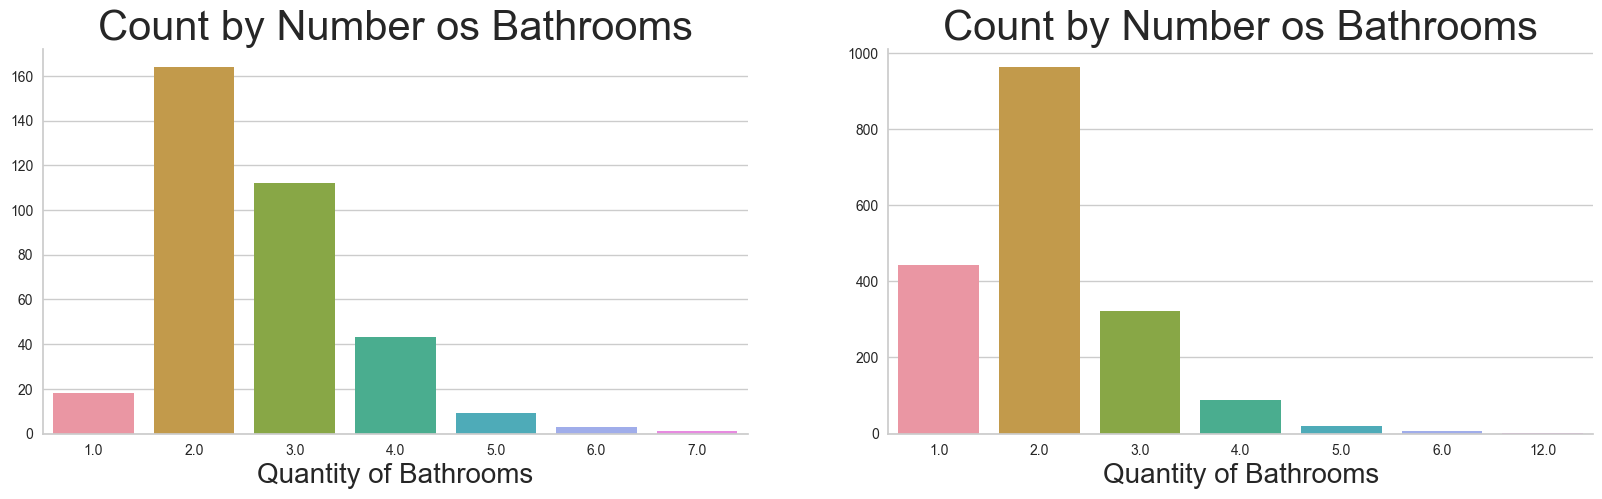

In [63]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df10.loc[df10['cluster']==0] , x='number_of_bathrooms')
plt.title('Count by Number os Bathrooms', fontsize=30)
plt.xlabel('Quantity of Bathrooms', fontsize=20)
plt.ylabel('')
sns.despine()
plt.subplot(1, 2, 2)
sns.countplot(data=df10.loc[df10['cluster']==1] , x='number_of_bathrooms')
plt.title('Count by Number os Bathrooms', fontsize=30)
plt.xlabel('Quantity of Bathrooms', fontsize=20)
plt.ylabel('')
sns.despine();

In [64]:
df10.loc[df10['cluster']==0, 'number_of_bathrooms'].value_counts(normalize=True)

2.0    0.468571
3.0    0.320000
4.0    0.122857
1.0    0.051429
5.0    0.025714
6.0    0.008571
7.0    0.002857
Name: number_of_bathrooms, dtype: float64

In [65]:
df10.loc[df10['cluster']==1, 'number_of_bathrooms'].value_counts(normalize=True)

2.0     0.523085
1.0     0.240087
3.0     0.174362
4.0     0.047800
5.0     0.010320
6.0     0.003802
12.0    0.000543
Name: number_of_bathrooms, dtype: float64

### 10.1.3 Number of Beds

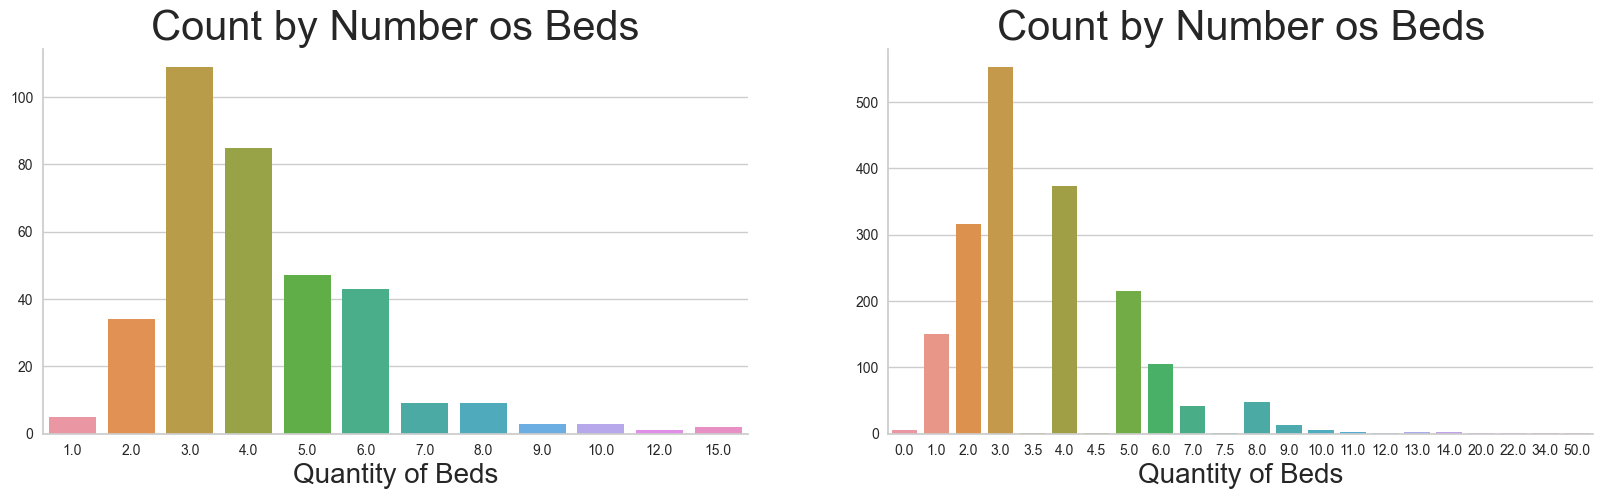

In [66]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=df10.loc[df10['cluster']==0] , x='number_of_beds')
plt.title('Count by Number os Beds', fontsize=30)
plt.xlabel('Quantity of Beds', fontsize=20)
plt.ylabel('')
sns.despine()
plt.subplot(1, 2, 2)
sns.countplot(data=df10.loc[df10['cluster']==1] , x='number_of_beds')
plt.title('Count by Number os Beds', fontsize=30)
plt.xlabel('Quantity of Beds', fontsize=20)
plt.ylabel('')
sns.despine();

In [67]:
df10.loc[df10['cluster']==0, 'number_of_beds'].value_counts(normalize=True)

3.0     0.311429
4.0     0.242857
5.0     0.134286
6.0     0.122857
2.0     0.097143
7.0     0.025714
8.0     0.025714
1.0     0.014286
10.0    0.008571
9.0     0.008571
15.0    0.005714
12.0    0.002857
Name: number_of_beds, dtype: float64

In [68]:
df10.loc[df10['cluster']==1, 'number_of_beds'].value_counts(normalize=True)

3.0     0.300380
4.0     0.202607
2.0     0.171646
5.0     0.116784
1.0     0.081477
6.0     0.057034
8.0     0.025530
7.0     0.022814
9.0     0.007061
10.0    0.003259
0.0     0.003259
13.0    0.001630
11.0    0.001086
14.0    0.001086
7.5     0.000543
3.5     0.000543
22.0    0.000543
4.5     0.000543
12.0    0.000543
20.0    0.000543
34.0    0.000543
50.0    0.000543
Name: number_of_beds, dtype: float64

### 10.1.4 Safety Features

In [69]:
print(f"{round((1-df10.loc[df10['extintordeincendio']==1, 'cluster'].mean())*100)}% of properties with fire extinguishers are in cluster 0")

18% of properties with fire extinguishers are in cluster 0


In [70]:
print(f"{round((1-df10.loc[df10['detectordefumaça']==1, 'cluster'].mean())*100)}% of properties with smoke detector are in cluster 0")

16% of properties with smoke detector are in cluster 0


In [71]:
print(f"{round((1-df10.loc[df10['alarmedemonoxidodecarbono']==1, 'cluster'].mean())*100)}% of properties with carbon monoxide alarm are in cluster 0")

12% of properties with carbon monoxide alarm are in cluster 0


In [72]:
print(f"{round((1-df10.loc[df10['kitdeprimeirossocorros']==1, 'cluster'].mean())*100)}% of properties with First aid kit are in cluster 0")

26% of properties with First aid kit are in cluster 0


### 10.1.5 Best Location in the City

In [73]:
# temp = df10.iloc[0:500][['latitude', 'longitude']].apply(lambda x: get_district(x), axis=1)
# temp1 = df10.iloc[500:1000][['latitude', 'longitude']].apply(lambda x: get_district(x), axis=1)
# temp2 = df10.iloc[1000:1500][['latitude', 'longitude']].apply(lambda x: get_district(x), axis=1)
# temp3 = df10.iloc[1500:][['latitude', 'longitude']].apply(lambda x: get_district(x), axis=1)
# address = [temp, temp1, temp2, temp3]
# pickle.dump(address, open('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\interim\\address.pkl', 'wb'))

In [367]:
address = pickle.load(open('D:\\My Drive\\Pessoal\\Projetos\\seazone_code_challenge\\data\\interim\\address.pkl', 'rb'))

temp = address[0]
temp1 = address[1]
temp2 = address[2]
temp3 = address[3]

temp = temp.append(temp1).append(temp2).append(temp3)

df10['address'] = temp

df10['district'] = df10['address'].apply(lambda x: x[0].split(',')[1])

district_list = df10['district'].value_counts().keys().to_list()

bairros = []
for i in district_list:
    i = i.replace(' ', '')
    if i.isalpha():
        bairros.append(i)

bairros.append('VilaNova')
bairros.append('RioPequeno')

temp = 'Areal RegiãoGeográficaImediatadeItajaí RuaGuilhermeMarian RuaJoséAlexandreRocha RuaBeijaFlor RodoviaGovernadorMárioCovas RuaIgrejaEvangélicaAssembleiadeDeus AvenidaGovernadorCelsoRamos AvenidaNereuRamos LoteamentoItapema'.split()

for i in temp:
    try:
        bairros.remove(i)
    except:
        pass

def district_clean(x):
    x = x[0].replace(' ', '')
    for i in bairros:
        if i in x:
            return i

df10['district'] = df10['address'].apply(lambda x: district_clean(x))

C:\Users\Samoel\AppData\Local\Temp\ipykernel_7220\1232301236.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Samoel\AppData\Local\Temp\ipykernel_7220\1232301236.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\Samoel\AppData\Local\Temp\ipykernel_7220\1232301236.py:8: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



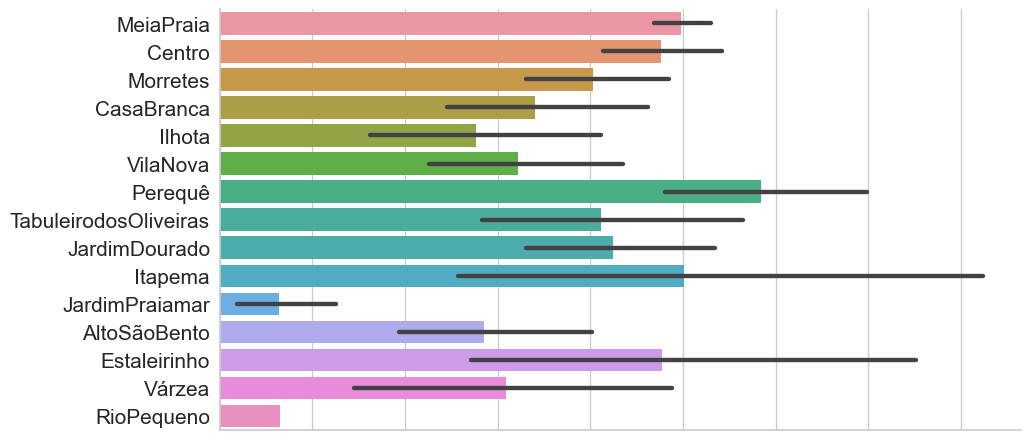

In [369]:
ax = sns.catplot(data=df10, x='gross_revenue', y='district', kind='bar', aspect=2, estimator='mean')
ax.tick_params(labelbottom=False, labelsize=15)
plt.ylabel('')
plt.xlabel('');

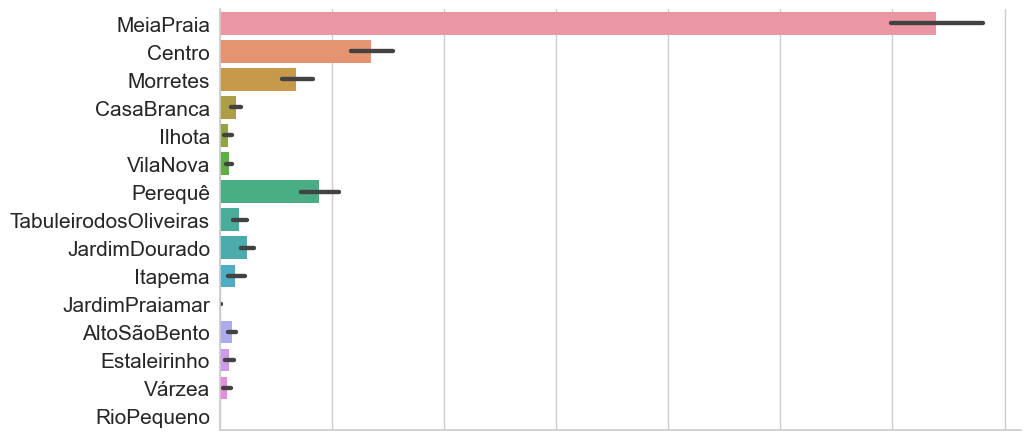

In [370]:
ax = sns.catplot(data=df10, x='gross_revenue', y='district', kind='bar', aspect=2, estimator='sum')
ax.tick_params(labelbottom=False, labelsize=15)
plt.ylabel('')
plt.xlabel('');

In [364]:
df10.groupby('district').agg({'gross_revenue':'mean'}).reset_index().sort_values('gross_revenue', ascending=False)

,district,gross_revenue
10,Perequê,116876.874172
5,Itapema,100201.555556
8,MeiaPraia,99611.991420
3,Estaleirinho,95453.882353
2,Centro,95333.616608
6,JardimDourado,84845.263158
12,TabuleirodosOliveiras,82337.571429
9,Morretes,80619.609467
1,CasaBranca,68043.976744
13,VilaNova,64469.160000


In [365]:
df10.groupby('district').agg({'gross_revenue':'sum'}).reset_index().sort_values('gross_revenue', ascending=False)

,district,gross_revenue
8,MeiaPraia,127702573.0
2,Centro,26979413.5
10,Perequê,17648408.0
9,Morretes,13624714.0
6,JardimDourado,4836180.0
12,TabuleirodosOliveiras,3458178.0
1,CasaBranca,2925891.0
5,Itapema,2705442.0
0,AltoSãoBento,2110269.0
3,Estaleirinho,1622716.0


### The best configuration of the building is:
* Localized at Meia Praia
* 3 Bedrooms with 3 beds in total
* 2 Bathrooms
* Com Extintor de Incêndio e Kit de primeiros socorros